## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 Inception model (GoogLeNet)을 통한 classification

<br>

- **임규연 (lky473736)**
- 2024.09.01. ~ 2024.09.04.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------


## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. GoogLeNet (inception model)을 이용한다. **IEEE Sensor 저널에 등록된 <iSPLInception: Redefining the State-of-the-Art for Human Activity Recognition>에서 나온 모델 구조 및 소스코드를 참고하여 HARTH를 classification한다.**

- **Reference**
    - https://github.com/MyungKyuYi/HAR/blob/main/iSPLInception_WISDM_0730.ipynb
    - https://github.com/rmutegeki/iSPLInception
    - https://github.com/healthDataScience/deep-learning-HAR/blob/master/HAR-CNN-Inception.ipynb
    - https://ieeexplore.ieee.org/document/9425494

In [56]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [57]:
'''
    원래 모든 harth 디렉토리의 데이터파일을 병합한 데이터셋을 사용하려고 했으나, 
    records의 양이 많아 한 epoch 당 10분의 학습시간이 걸린다.
    따라서, S006.csv, S008.csv, S009.csv, S010.csv를 병합하여 학습하도록 한다.
    test set은 S010.csv와 S012.csv, 'S014.csv', 를 사용한다.
'''

import glob

file_name_train = ['../../data/harth/' + compo for compo in ['S006.csv', 'S008.csv', 'S009.csv', 
                                                             'S010.csv', 'S012.csv', 'S013.csv']]
file_name_test = ['../../data/harth/' + compo for compo in ['S014.csv', 
                                                            'S015.csv', 
                                                            'S016.csv', 
                                                            'S017.csv']]

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")
print ("harth 디렉토리 내 파일의 이름 : ", sorted(all_files))

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in file_name_train :
    df = pd.read_csv(filename)
    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)  # 병합 (header는 ignore)
train_df = merged_df

df_list = []

for filename in file_name_test :
    df = pd.read_csv(filename)
    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)  # 병합 (header는 ignore)
test_df = merged_df

print ()
print (train_df.shape)
print (train_df.head())

print ()
print (test_df.shape)
print (test_df.head())

harth 디렉토리 내 파일의 이름 :  ['../../data/harth/S006.csv', '../../data/harth/S008.csv', '../../data/harth/S009.csv', '../../data/harth/S010.csv', '../../data/harth/S012.csv', '../../data/harth/S013.csv', '../../data/harth/S014.csv', '../../data/harth/S015.csv', '../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S018.csv', '../../data/harth/S019.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S022.csv', '../../data/harth/S023.csv', '../../data/harth/S024.csv', '../../data/harth/S025.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv', '../../data/harth/S028.csv', '../../data/harth/S029.csv']

(2085302, 8)
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732 -0.298644   
1  2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547  0.286944   
2  2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442 -0.078423   
3  2

In [58]:
# timestamp 열 제거, index 열 제거

print ("prev : ", train_df.columns, test_df.columns)

train_df = train_df.drop('timestamp', axis=1)
test_df = test_df.drop('timestamp', axis=1)
test_df = test_df.drop('index', axis=1)

print ("after : ", train_df.columns, test_df.columns)

prev :  Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label'],
      dtype='object') Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label', 'index'],
      dtype='object')
after :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object') Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [59]:
# target의 class 도수를 확인 (숫자로)

train_df['label'].value_counts()
print ()
test_df['label'].value_counts()

label
7      839310
6      207428
1      158350
8      156786
3       56885
13      27984
4       20600
5       19534
2       13380
14       5179
130      1310
140       160
Name: count, dtype: int64

In [60]:
# 결측치 확인 및 결측치를 각 열의 평균값으로 대체

print (train_df.isnull().sum())
print (test_df.isnull().sum())

train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64
back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64


In [61]:
# labelencoding을 통하여 각 label을 0-based 및 순서대로 구성

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.fit_transform(test_df['label'])

train_df['label'].value_counts()
test_df['label'].value_counts()

label
6     839310
5     207428
0     158350
7     156786
2      56885
8      27984
3      20600
4      19534
1      13380
9       5179
10      1310
11       160
Name: count, dtype: int64

In [62]:
'''
    현재 label이 5인 records에만 너무 많이 편중되어 있다. 
    따라서 각 label이 20000개를 가질 수 있도록 oversampling한다.
'''

# class 별로 데이터 추출 -> 복제하는 방식
    
# 만약 20000개보다 샘플이 적음 -> replace == True로 복제
# 만약 20000개보다 샘플이 많음 -> 복제
    
def oversampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    # 리스트에 저장된 데이터프레임들을 합침
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

train_df_resampled = oversampling(train_df, 'label', max_size=20000)
test_df_resampled = oversampling(test_df, 'label', max_size=20000)

print (train_df_resampled['label'].value_counts())
print (test_df_resampled['label'].value_counts())

label
5     20000
0     20000
2     20000
6     20000
3     20000
4     20000
7     20000
10    20000
8     20000
9     20000
11    20000
1     20000
Name: count, dtype: int64
label
5     20000
2     20000
0     20000
4     20000
7     20000
1     20000
3     20000
6     20000
8     20000
9     20000
10    20000
11    20000
Name: count, dtype: int64


In [63]:
# split the input, target

train_harth_input = train_df_resampled.drop(columns=['label'])
train_harth_target = train_df_resampled['label']

test_harth_input = test_df_resampled.drop(columns=['label'])
test_harth_target = test_df_resampled['label']

print (train_harth_target.shape, test_harth_target.shape)

(240000,) (240000,)


In [64]:
# z-score normalization 수행

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_harth_input_scaled = scaler.fit_transform(train_harth_input)
train_harth_target_reshaped = train_harth_target.to_numpy().reshape(-1, 1)

test_harth_input_scaled = scaler.fit_transform(test_harth_input)
test_harth_target_reshaped = test_harth_target.to_numpy().reshape(-1, 1)

# normalization된 입력 데이터와 label 데이터를 결합하여 DataFrame 생성
train_df = pd.DataFrame(
    np.hstack((train_harth_input_scaled, train_harth_target_reshaped)),
    columns=[feature for feature in train_df_resampled.columns[:-1]] + ['label']
)

test_df = pd.DataFrame(
    np.hstack((test_harth_input_scaled, test_harth_target_reshaped)),
    columns=[feature for feature in test_df_resampled.columns[:-1]] + ['label']
)

# label 열을 float64에서 int64로 변경
train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

print (train_df)
print (test_df)

          back_x    back_y    back_z   thigh_x   thigh_y   thigh_z  label
0       0.304273  1.234325  1.044555 -6.699851 -1.070791  0.781626      5
1       0.864420  1.169907  0.629065  2.741973  0.406831  0.198571      5
2      -0.695458  0.822050 -0.732748  1.267413 -0.515105 -1.152756      5
3       0.575627  0.203825 -0.417527 -1.125317 -2.716835 -0.688259      5
4       1.290591 -0.045286 -0.582888  0.460762  0.038325 -1.371632      5
...          ...       ...       ...       ...       ...       ...    ...
239995 -0.507708  1.159386 -0.558582  1.447315 -0.125498 -1.595577      1
239996 -0.115992 -0.740227 -0.356966  0.100586  2.672638  1.817968      1
239997  1.631935 -0.502545 -0.272554  0.435829 -0.155600 -0.126495      1
239998 -5.415137  1.147851 -0.156048  0.608519  0.962556 -4.298694      1
239999  1.924874  0.056340  0.769418 -4.487470  4.059999 -0.813959      1

[240000 rows x 7 columns]
          back_x    back_y    back_z   thigh_x   thigh_y   thigh_z  label
0      -0.2

In [65]:
'''
    시계열 데이터를 프레임 크기와 홉 크기로 분할하는 건데, 이는 이전에 transformer_classification_HARTH.ipynb에서 다루었던
    get_frames API와 원리가 동일하다.
    
    아래 함수는 get_frames와 동일히 현재 x, y, z를 split하고, step(transformer에서는 hop_size)가 일종의 이동량의 역할을 한다.
    최종적으로는 split된 형태와 그에 맞는 target인 labels를 반환하고 있다.
    
    아래를 현재 HARTH 데이터셋에 맞게끔 변형할 것이다. 다음 셀을 참고.
'''

def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        # Finding the most frequent label within the segment
        segment_labels = df[label_name][i:i+time_steps].values
        label = np.bincount(segment_labels).argmax()
        
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [66]:
# def segments(df, time_steps, step, label_name):
#     N_FEATURES = 3
#     segments = []
#     labels = []
#     for i in range(0, len(df) - time_steps, step):
#         xs = df['X'].values[i:i+time_steps]
#         ys = df['Y'].values[i:i+time_steps]
#         zs = df['Z'].values[i:i+time_steps]
        
#         # Finding the most frequent label within the segment
#         segment_labels = df[label_name][i:i+time_steps].values
#         label = np.bincount(segment_labels).argmax()
        
#         segments.append([xs, ys, zs])
#         labels.append(label)
    
#     reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
#     labels = np.asarray(labels)
    
#     return reshaped_segments, labels

# 위 함수를 HARTH 데이터셋에 맞게끔 변형.

def segments(df, time_steps, step, label_name): # label 이름
    N_FEATURES = 6  # 6개의 특징 

    segments = []
    labels = []
    
    for i in range(0, len(df) - time_steps + 1, step):
        back_x = df['back_x'].values[i: i + time_steps]
        back_y = df['back_y'].values[i: i + time_steps]
        back_z = df['back_z'].values[i: i + time_steps]
        thigh_x = df['thigh_x'].values[i: i + time_steps]
        thigh_y = df['thigh_y'].values[i: i + time_steps]
        thigh_z = df['thigh_z'].values[i: i + time_steps]

        # 해당 구간의 레이블에서 가장 많이 나타나는 레이블 선택
        segment_labels = df[label_name][i:i+time_steps].values
        segment_labels = segment_labels.astype(int)  # 정수형으로 변환
        label = np.bincount(segment_labels).argmax()
        
        segments.append([back_x, back_y, back_z, thigh_x, thigh_y, thigh_z])
        labels.append(label)

    # reshape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [67]:
# train set, test set split

TIME_PERIOD = 50
STEP_DISTANCE = 40 
'''
    TIME_PERIOD : 일종의 df가 잘라지는 records 수
    STEP_DISTANCE : df가 잘라지고 이동하여 겹치는 량. 여기서는 50 - 40 = 10. 뒤쪽 10개의 records가 겹친다.
'''
LABEL = 'label'

X_train, y_train = segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)
X_test, y_test = segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5999, 50, 6) (5999,)
(5999, 50, 6) (5999,)


In [68]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Activation, Flatten, Dense, 
                                     Reshape, TimeDistributed, MaxPooling1D, LSTM, Dropout, 
                                     Bidirectional, Input, GlobalAveragePooling1D, Concatenate, 
                                     MaxPool1D, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [69]:
# 다중 분류를 위해 softmax 도입, loss는 sparse categorical crossentropy (기존 : categorical crossentropy)

out_activ = 'softmax'
out_loss = SparseCategoricalCrossentropy()

In [70]:
# CNN 모델 정의

def cnn(x_shape,
        n_classes,
        filters,
        fc_hidden_nodes,
        learning_rate=0.01, regularization_rate=0.01,
        metrics=None):
    if metrics is None:
        metrics = ['accuracy']
    dim_length = x_shape[1]  # sample 
    dim_channels = x_shape[2]  # channel
    dim_output = n_classes
    weightinit = 'lecun_uniform'  # weight를 초기화하는 hyperparameter
    m = Sequential()

    # batchnormalization
    m.add(BatchNormalization(input_shape=(dim_length, dim_channels)))

    # 합성곱 -> batchnormalization -> ReLU Activation을 filter_number만큼 추가
    for filter_number in filters:
        m.add(Conv1D(filter_number, kernel_size=3, padding='same',
                     kernel_regularizer=l2(regularization_rate),
                     kernel_initializer=weightinit))
        m.add(BatchNormalization())
        m.add(Activation('relu'))

    # dense layer
    m.add(Flatten())
    m.add(Dense(units=fc_hidden_nodes,
                kernel_regularizer=l2(regularization_rate),
                kernel_initializer=weightinit))
    m.add(Activation('relu')) # 활성화 추가

    # 출력층
    m.add(Dense(units=dim_output, kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate)))
    m.add(BatchNormalization())
    m.add(Activation(out_activ)) # out_activ == softmax

    # compiling
    m.compile(loss=out_loss,
              optimizer=Adam(lr=learning_rate),
              metrics=metrics)

    return m

In [71]:
# CNN-LSTM 모델 정의

def cnn_lstm(x_shape,
             n_classes,
             n_hidden=128,
             learning_rate=0.01,
             n_steps=4,
             length=32,
             n_signals=9,
             regularization_rate=0.01,
             cnn_depth=3,
             lstm_depth=2,
             metrics=['accuracy']):
    """ CNN1D_LSTM 버전 1: 하나의 윈도우를 여러 작은 프레임으로 나누고, 각 프레임에 CNN 적용
    - 입력 데이터 형식: [None, n_frames, n_timesteps, n_signals]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    # CNN에 맞는 reshape -> batchnormalization
    m.add(Reshape((n_steps, length, n_signals), input_shape=_input_shape))
    m.add(BatchNormalization())

    # TimeDistributed를 사용하여 CNN 적용하기
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))

    # LSTM 추가
    m.add(TimeDistributed(Flatten()))
    for _ in range(lstm_depth-1):
        m.add(LSTM(n_hidden, return_sequences=True, kernel_regularizer=l2(regularization_rate)))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.5))

    # 출력층
    m.add(Dense(100, activation='relu', kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    # compiling
    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    
    return m

In [72]:
# Vanilla LSTM 모델 정의

def vanilla_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 metrics=['accuracy']):
    """ 3D 데이터 요구: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    m = Sequential()

    # LSTM만 구성함 (vanilla)
    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.3))

    # 출력층 
    m.add(Dense(100, activation='relu'))
    m.add(Dense(n_classes, activation=out_activ, kernel_regularizer=l2(regularization_rate)))

    # compiling
    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=metrics)
    return m

In [73]:
# Stacked LSTM 모델 정의

def stacked_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 depth=2,
                 metrics=['accuracy']):
    """ 3D 데이터 요구: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    m = Sequential()

    # dense
    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Dense(100, activation='relu', name='preprocess', kernel_regularizer=l2(regularization_rate)))

    # LSTM층을 2개 stack
    m.add(LSTM(n_hidden, return_sequences=True, kernel_regularizer=l2(regularization_rate)))
    m.add(Dropout(0.5))
    m.add(LSTM(n_hidden))

    # 출력층
    m.add(Dense(100, activation='relu'))
    m.add(Dense(n_classes, activation=out_activ, name="output"))

    # compiling
    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    return m


In [74]:
# BiLSTM 모델 정의

def bilstm(x_shape,
           n_classes,
           n_hidden=128,
           learning_rate=0.01,
           regularization_rate=0.01,
           merge_mode='concat', # concatenation함
           depth=2,
           metrics=['accuracy']):
    """ 3D 데이터 요구: [n_samples, n_timesteps, n_features]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    # bidirectional하게 LSTM을 배치하고, merge함
    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Bidirectional(LSTM(n_hidden), merge_mode=merge_mode))

    # 출력층
    m.add(Dense(100, activation='relu', kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    # compiling
    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m

In [75]:
# iSPLInception 모델 정의

def ispl_inception(x_shape,
                   n_classes,
                   filters_number,
                   network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy']):
    dim_length = x_shape[1]  # sample
    dim_channels = x_shape[2]  # channel
    weightinit = 'lecun_uniform'  # weight initialization

    # Inception 정의
    def inception_module(input_tensor, stride=1, activation='relu'):

        # 채널 수가 1보다 큰 경우 Bottleneck 레이어 추가
        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=bottleneck_size,
                                     kernel_size=1,
                                     padding='same',
                                     activation=activation,
                                     kernel_initializer=weightinit,
                                     use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_sizes = [max_kernel_size // (2 ** i) for i in range(3)]
        conv_list = [] # Conv layer를 담은 list

        # kernel을 여러개 추가하여 layer 추가 (Conv)
        for kernel_size in kernel_sizes:
            conv_list.append(Conv1D(filters=filters_number,
                                    kernel_size=kernel_size,
                                    strides=stride,
                                    padding='same',
                                    activation=activation,
                                    kernel_initializer=weightinit,
                                    kernel_regularizer=l2(regularization_rate),
                                    use_bias=False)(input_inception))

        # maxpooling layer 추가
        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        # 1 * 1 conv layer 추가
        conv_last = Conv1D(filters=filters_number,
                           kernel_size=1,
                           padding='same',
                           activation=activation,
                           kernel_initializer=weightinit,
                           kernel_regularizer=l2(regularization_rate),
                           use_bias=False)(max_pool_1)

        conv_list.append(conv_last)

        # conv layer
        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    # Residual 연결을 위하여 shortcut layer 추가함
    def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]),
                            kernel_size=1,
                            padding='same',
                            kernel_initializer=weightinit,
                            kernel_regularizer=l2(regularization_rate),
                            use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    # modelling 
    input_layer = Input((dim_length, dim_channels))
    x = BatchNormalization()(input_layer)  # BatchNormalization 추가
    input_res = x

    # 네트워크 depth에 따른 Inception 모듈을 반복
    for depth in range(network_depth):
        x = inception_module(x)

        # Residual 연결을 3단계마다 추가 (연결을 위함)
        if use_residual and depth % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x

    # GlobalAveragePooling -> 출력층
    gap_layer = GlobalAveragePooling1D()(x)
    output_layer = Dense(n_classes, activation=out_activ,
                         kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate))(gap_layer)

    # compiling
    m = Model(inputs=input_layer, outputs=output_layer)
    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m


In [76]:
n_classes = len(df['label'].unique())  # 클래스 개수

use_residual = True  # Residual(잔차) 연결 사용 여부

use_bottleneck = True  # Bottleneck(병목) 레이어 사용 여부

learning_rate = 0.0005  # 학습률

regularization_rate = 0.00593  # 정규화 비율

network_depth = 5  # 네트워크 깊이 (Inception 모듈 개수)

filters_number = 64  # 필터 수

max_kernel_size = 68  # 최대 커널 크기

out_activ = 'softmax'  # 출력 레이어 활성화 함수

out_loss = SparseCategoricalCrossentropy()  # 출력 레이어 손실 함수

print(f"클래스 개수 (n_classes): {n_classes}")
print(f"Residual 연결 사용 여부 (use_residual): {use_residual}")
print(f"Bottleneck 레이어 사용 여부 (use_bottleneck): {use_bottleneck}")
print(f"학습률 (learning_rate): {learning_rate}")
print(f"정규화 비율 (regularization_rate): {regularization_rate}")
print(f"네트워크 깊이 (network_depth): {network_depth}")
print(f"필터 수 (filters_number): {filters_number}")
print(f"최대 커널 크기 (max_kernel_size): {max_kernel_size}")
print(f"출력 레이어 활성화 함수 (out_activ): {out_activ}")
print(f"출력 레이어 손실 함수 (out_loss): {out_loss}")

'''
    기존 out_loss의 reduction은 auto (시스템에 의한 자동)으로 되었으나 'none'으로 변경함 (기본값)
'''

클래스 개수 (n_classes): 12
Residual 연결 사용 여부 (use_residual): True
Bottleneck 레이어 사용 여부 (use_bottleneck): True
학습률 (learning_rate): 0.0005
정규화 비율 (regularization_rate): 0.00593
네트워크 깊이 (network_depth): 5
필터 수 (filters_number): 64
최대 커널 크기 (max_kernel_size): 68
출력 레이어 활성화 함수 (out_activ): softmax
출력 레이어 손실 함수 (out_loss): <keras.src.losses.losses.SparseCategoricalCrossentropy object at 0x13bca5810>


"\n    기존 out_loss의 reduction은 auto (시스템에 의한 자동)으로 되었으나 'none'으로 변경함 (기본값)\n"

In [77]:
# modelling

model = ispl_inception(X_train.shape, n_classes, filters_number, network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, 
                      show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True,
                      show_shapes=True,
                      show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 6)     │         24 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 50, 32)    │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 50, 6)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 50, 64)    │     40,960 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 50, 64)    │     20,480 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 50, 64)    │     10,240 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 50, 64)    │        384 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 50, 256)   │          0 │ conv1d_27[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_28[0][0],  │
│                     │                   │            │ conv1d_29[0][0],  │
│                     │                   │            │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ concatenate_5[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 50, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 50, 32)    │      8,192 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 50, 256)   │          0 │ activation_6[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 50, 64)    │     40,960 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 50, 64)    │     20,480 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 50, 64)    │     10,240 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 50, 64)    │     16,384 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 50, 256)   │          0 │ conv1d_32[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_33[0][0],  │
│                     │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ concatenate_6[0]

 Total params: 468,068 (1.79 MB)

 Trainable params: 464,984 (1.77 MB)

 Non-trainable params: 3,084 (12.05 KB)

In [78]:
# one-hot encoding

# from tensorflow.keras.utils import to_categorical

# print ("before : ", y_train.shape, y_test.shape)

# y_train = to_categorical(y_train, num_classes=n_classes)
# y_test = to_categorical(y_test, num_classes=n_classes)

# print ("after : ", y_train.shape, y_test.shape)

# print ("X_train, X_test : ", X_train.shape, X_test.shape)

In [79]:
# fit

# X_train = np.asarray(X_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.int32)

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_train dtype:", X_train.dtype)
# print("y_train dtype:", y_train.dtype)

# model.compile(
#     loss=out_loss,
#     optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
#     metrics=['accuracy']
# )

validation_split = 0.2
history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=50,
    verbose=True,
    validation_split=validation_split
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 518ms/step - accuracy: 0.5563 - loss: 11.6294 - val_accuracy: 0.0000e+00 - val_loss: 14.7817
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.8524 - loss: 2.6334 - val_accuracy: 0.0000e+00 - val_loss: 5.4519
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.8737 - loss: 1.3609 - val_accuracy: 0.0000e+00 - val_loss: 4.0189
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.8661 - loss: 0.9740 - val_accuracy: 0.0000e+00 - val_loss: 3.8004
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.8720 - loss: 0.9572 - val_accuracy: 0.0000e+00 - val_loss: 4.9839
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.8678 - loss: 0.9117 - val_accuracy: 0.0000e+00 - val_loss: 3.9601
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.8756 - loss: 0.8082 - val_accuracy: 0.0000e+00 - val_loss: 4.2357
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.8906 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9053 - loss: 0.4769 - val_accuracy: 0.0117 - val_loss: 10.8615


In [80]:
# evaluate

model.evaluate(X_test, y_test, verbose=1)# evaluate

188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.2914 - loss: 4.0157


[4.486938953399658, 0.2775462567806244]

{'accuracy': [0.7276515960693359, 0.8610126972198486, 0.8745571970939636, 0.8658053874969482, 0.8728901743888855, 0.8774744868278503, 0.8766409754753113, 0.8878933191299438, 0.8716399073600769, 0.8772661089897156, 0.8837257623672485, 0.8870598077774048, 0.8801833987236023, 0.883309006690979, 0.886017918586731, 0.8883100748062134, 0.8870598077774048, 0.879558265209198, 0.8897687196731567, 0.8780996203422546, 0.8899770975112915, 0.8883100748062134, 0.8858095407485962, 0.8906022310256958, 0.8951864838600159, 0.8853927850723267, 0.8793498873710632, 0.8960199952125549, 0.8918524980545044, 0.883309006690979, 0.8870598077774048, 0.8951864838600159, 0.8881016969680786, 0.8985205292701721, 0.8926859498023987, 0.876849353313446, 0.8899770975112915, 0.8818503618240356, 0.8891435861587524, 0.8872681856155396, 0.8883100748062134, 0.8976870179176331, 0.8874765634536743, 0.883309006690979, 0.8964367508888245, 0.8914357423782349, 0.8985205292701721, 0.8872681856155396, 0.8991456627845764, 0.8987289071

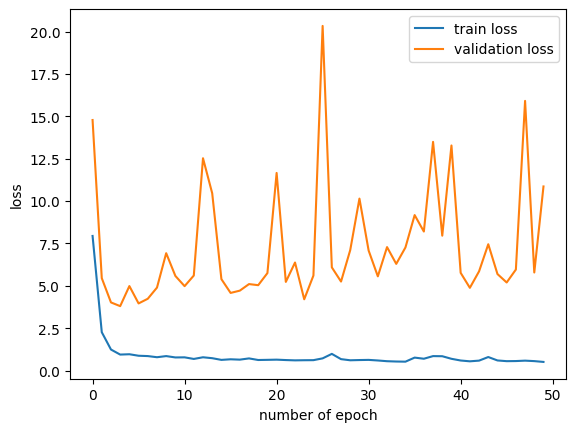

In [81]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

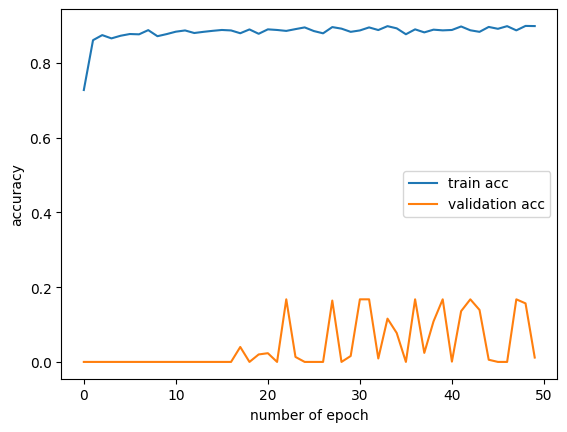

In [82]:
# acc 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train acc', 'validation acc'])
plt.show() 

In [83]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = model.predict(X_test)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step
- test data confusion matrix -

[[131   0 327   0   0   0  10   0   6   0  26   0]
 [  0   0   0   0 500   0   0   0   0   0   0   0]
 [ 22   0 404   0   0   0  10   0   9   0  55   0]
 [174   0 305   0   0   0   0   0  20   0   1   0]
 [  0   0   0 334 166   0   0   0   0   0   0   0]
 [  3   0 388   0   0   0  55   0   0   0  54   0]
 [  0   0  49   0   0   0 395   0  20   0  36   0]
 [  5   0   2   0   0   0 322 171   0   0   0   0]
 [  5   0  43   0   0   0  17   0 382   0  53   0]
 [  0   0   0 198 302   0   0   0   0   0   0   0]
 [  0   0   6 478   0   0   0   0   0   0  16   0]
 [  0   0 413  86   0   0   0   0   0   0   0   0]]

 --------------- 

- test data report of classification -

              precision    recall  f1-score   support

           0       0.39      0.26      0.31       500
           1       0.00      0.00      0.00       500
           2       0.21      0.81      0.33       500
           3       0.00      0.00 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

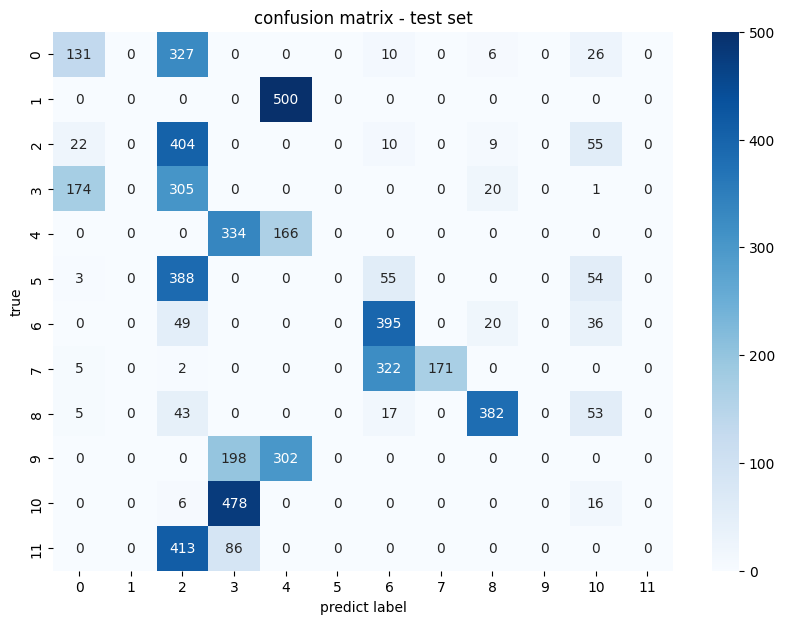

In [84]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - test set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()